In [1]:
import torch
import collections
import datasets
import numpy as np
import pandas as pd
import tqdm
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os

/Users/ayush/Desktop/MINI PROJECT/pytorch-sentiment-analysis-main/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
train_data = pd.read_csv('/Users/ayush/Desktop/MINI PROJECT/pytorch-sentiment-analysis-main/legacy/data/train.csv')
valid_data = pd.read_csv('/Users/ayush/Desktop/MINI PROJECT/pytorch-sentiment-analysis-main/legacy/data/valid.csv')
test_data = pd.read_csv('/Users/ayush/Desktop/MINI PROJECT/pytorch-sentiment-analysis-main/legacy/data/test.csv')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

In [6]:
train_data["input_ids"] = train_data["quote"].apply(lambda x: tokenize_function({"text": x})["input_ids"]) 
valid_data["input_ids"] = valid_data["quote"].apply(lambda x: tokenize_function({"text": x})["input_ids"]) 
test_data["input_ids"] = test_data["quote"].apply(lambda x: tokenize_function({"text": x})["input_ids"]) 

In [7]:
special_tokens = ['<unk>', '<pad>']

In [8]:
def build_vocab(data, min_freq, special_tokens):
    all_tokens = [token for example_tokens in data["input_ids"] for token in example_tokens]
    counter = Counter(all_tokens)
    filtered_tokens = [token for token, freq in counter.items() if freq >= min_freq]
    vocab_tokens = special_tokens + filtered_tokens
    token_to_idx = {token: idx for idx, token in enumerate(vocab_tokens)}
    return token_to_idx

In [9]:
min_freq = 5

In [10]:
vocab = build_vocab(train_data, min_freq, special_tokens)
vocab_size = len(vocab)

In [11]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [12]:
def numericalize_example(example, vocab):
    ids = [vocab.get(token, unk_index) for token in example["input_ids"]]
    return {"ids": ids}

train_data["ids"] = train_data.apply(lambda x: numericalize_example(x, vocab)["ids"], axis=1)
valid_data["ids"] = valid_data.apply(lambda x: numericalize_example(x, vocab)["ids"], axis=1)
test_data["ids"] = test_data.apply(lambda x: numericalize_example(x, vocab)["ids"], axis=1)

In [13]:
def numericalize_example(example, vocab):
    ids = [vocab.get(token, unk_index) for token in example["input_ids"]]
    return {"ids": ids}

train_data["ids"] = train_data.apply(lambda x: numericalize_example(x, vocab)["ids"], axis=1)
valid_data["ids"] = valid_data.apply(lambda x: numericalize_example(x, vocab)["ids"], axis=1)
test_data["ids"] = test_data.apply(lambda x: numericalize_example(x, vocab)["ids"], axis=1)

In [14]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch
    return collate_fn

In [15]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 512
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


In [16]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        embedded = self.embedding(ids)
        pooled = embedded.mean(dim=1)
        prediction = self.fc(pooled)
        return prediction

vocab_size = len(vocab)
embedding_dim = 300
output_dim = 2 

In [17]:
model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [18]:
model.embedding.weight.data.uniform_(-0.1, 0.1)

tensor([[ 7.3982e-02, -7.6504e-02,  2.0154e-02, -5.1287e-02,  7.7905e-02,
          6.0818e-02,  9.8143e-02,  5.0142e-03, -3.4126e-02,  8.1135e-02,
          6.9262e-02,  2.5685e-03,  4.2648e-02, -4.3600e-02,  5.7352e-02,
          6.4701e-02,  6.5090e-02, -5.2615e-02,  3.6773e-02, -1.9464e-02,
          9.7449e-02, -2.6803e-02, -6.1498e-02, -8.5190e-02,  8.9110e-02,
         -9.1730e-02, -2.2153e-02, -4.0395e-02, -5.7088e-02, -2.2296e-02,
         -2.4422e-02, -8.6448e-02, -4.3758e-02,  4.4371e-02,  3.8965e-02,
          8.9397e-02, -2.0915e-02, -8.4749e-02,  5.3695e-02, -3.4217e-02,
         -2.8949e-02,  4.7238e-02,  9.9693e-02,  8.5529e-02,  1.9860e-02,
         -1.9291e-02,  2.1476e-02, -2.7863e-02,  7.1237e-02,  2.3497e-02,
          6.3690e-02, -3.3678e-03,  1.2544e-02,  6.6739e-02, -4.5157e-02,
          8.7983e-02, -5.8320e-02,  7.4507e-02, -6.6778e-02, -8.1310e-02,
         -8.2940e-02, -4.7173e-03,  3.8768e-02,  1.8060e-02, -7.3089e-02,
         -3.5362e-02, -6.7732e-02,  3.

In [19]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [20]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [21]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [22]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [23]:
n_epochs = 10
best_valid_loss = float("inf")
metrics = collections.defaultdict(list)

In [24]:
for epoch in range(n_epochs):
    try:
        train_loss, train_acc = train(train_data_loader, model, criterion, optimizer, device)
        valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
        metrics["train_losses"].append(train_loss)
        metrics["train_accs"].append(train_acc)
        metrics["valid_losses"].append(valid_loss)
        metrics["valid_accs"].append(valid_acc)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "nbow.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
    except KeyError as e:
        print(f"KeyError: {e}. Please ensure the dataset contains the correct keys.")

training...:   0%|          | 0/1 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 1. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 1. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 0. Please ensure the dataset contains the correct keys.


training...:   0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 1. Please ensure the dataset contains the correct keys.


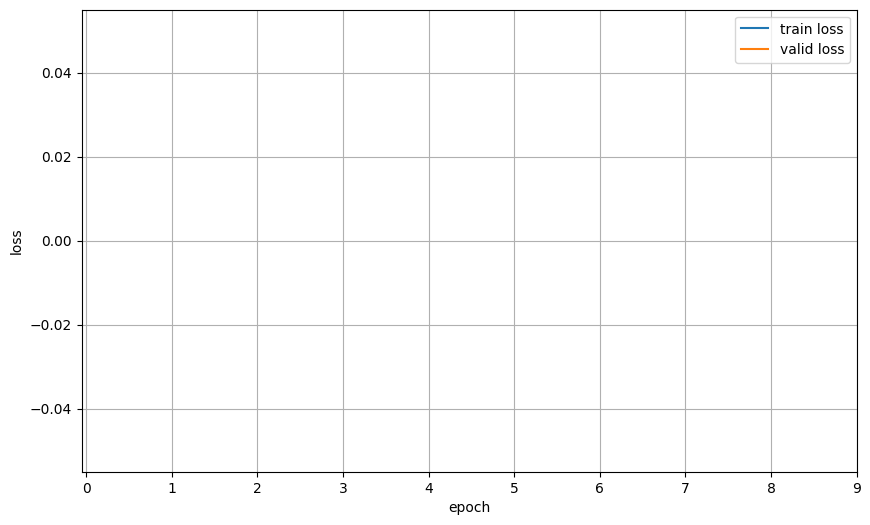

In [25]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()
plt.show()